In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision.transforms as transforms
from PIL import Image

In [2]:
%matplotlib widget

In [3]:
from models.diffusion import Model
from main import parse_args_and_config

In [4]:
args,config = parse_args_and_config("--config cifar10.yml --exp CIFAR --use_pretrained --sample --fid --timesteps 50 --eta 0 --ni --doc CIFAR".split( ))

INFO - main.py - 2024-08-16 10:19:31,214 - Using device: cuda


In [34]:
# data process 
datas =[]
targets = []
with open("CIFAR/datasets/cifar10/cifar-10-batches-py/data_batch_2",'rb') as f:
    entry = pickle.load(f, encoding="latin1")
    datas.append(entry["data"])
    if "labels" in entry:
         targets.extend(entry["labels"])
datas =  np.vstack( datas).reshape(-1, 3, 32, 32)
datas =  datas.transpose((0, 2, 3, 1))  # convert to HWC


tran_transform = transforms.Compose(
    [
        transforms.Resize(config.data.image_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
    ]
)

# 进入网络的是0-1 之间的归一化值，  xt = at*x0 + (1-at)*noise, 
# noise 是randn 的,符合01分布， x0 如果是0-255 ， 量级相差太大。 
# 网络预测的是noise, 所以最后不能有sigmoid，之类的强制小于1. 需要conv 输出。 范围从-oo 到 +oo，符合randn的范围大小。 


In [35]:
img = Image.fromarray(datas[0])

trans_x = tran_transform(img)

In [37]:
trans_x.max(),trans_x.min()

(tensor(0.8824), tensor(0.0196))

In [30]:
 Image?

Type:        module
String form: <module 'PIL.Image' from '/home/linwei/anaconda3/lib/python3.9/site-packages/PIL/Image.py'>
File:        ~/anaconda3/lib/python3.9/site-packages/PIL/Image.py
Docstring:   <no docstring>

In [6]:
model = Model(config)

In [7]:
ckpt = torch.load("diffusion_models_converted/ema_diffusion_cifar10_model/model-790000.ckpt",map_location="cpu")
model.load_state_dict(ckpt)
model.eval()
;

''

In [34]:

Ts = torch.arange(0,1000)
betas = torch.linspace(0.0001,0.02,1000)
alpha = 1-betas

alpha_bar = torch.cumprod(alpha,dim=0)
sqrt_alpha_bar = torch.sqrt(alpha_bar)
one_minus_alpha_bar = 1-alpha_bar
sqrt_one_minus_alpha_bar = torch.sqrt(one_minus_alpha_bar)




new_total_steps = 50
new_Ts = 20* torch.arange(50)

new_alpha_bar = alpha_bar.index_select(0,new_Ts)
new_alpha_bar_pre = torch.roll(new_alpha_bar,1,0)

new_sqrt_alpha_bar=sqrt_alpha_bar.index_select(0,new_Ts)
new_sqrt_alpha_bar_pre=torch.roll(new_sqrt_alpha_bar,1,0)

new_sqrt_one_minus_alpha_bar = sqrt_one_minus_alpha_bar.index_select(0,new_Ts)
new_sqrt_one_minus_alpha_bar_pre = torch.roll(new_sqrt_one_minus_alpha_bar,1,0)

coff_delta = 0
deltaT =  coff_delta * new_sqrt_one_minus_alpha_bar_pre/new_sqrt_one_minus_alpha_bar*torch.sqrt(1-new_alpha_bar/new_alpha_bar_pre)

coeff1 = torch.sqrt(1-new_alpha_bar_pre-deltaT**2)  # c1 系数 错误的用了new_sqrt_alpha_bar_pre 导致xt数值 越来越小，改过来之后就好了。 
coeff2 = deltaT



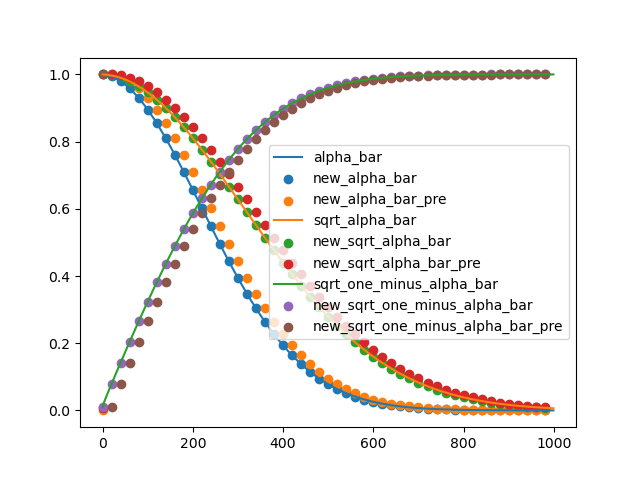

In [17]:
plt.figure()
# plt.plot(Ts,betas,label='betas')
# plt.plot(Ts,alpha,label='alpha')
plt.plot(Ts,alpha_bar,label='alpha_bar')
plt.scatter(new_Ts,new_alpha_bar,label='new_alpha_bar')
plt.scatter(new_Ts,new_alpha_bar_pre,label='new_alpha_bar_pre')

plt.plot(Ts,sqrt_alpha_bar,label='sqrt_alpha_bar')
plt.scatter(new_Ts,new_sqrt_alpha_bar,label='new_sqrt_alpha_bar')
plt.scatter(new_Ts,new_sqrt_alpha_bar_pre,label='new_sqrt_alpha_bar_pre')


plt.plot(Ts,sqrt_one_minus_alpha_bar,label='sqrt_one_minus_alpha_bar')
plt.scatter(new_Ts,new_sqrt_one_minus_alpha_bar,label='new_sqrt_one_minus_alpha_bar')
plt.scatter(new_Ts,new_sqrt_one_minus_alpha_bar_pre,label='new_sqrt_one_minus_alpha_bar_pre')

plt.legend()

In [28]:

xt = torch.randn(1,3,32,32)

with torch.no_grad():
    for step in  reversed(range(new_total_steps)): # di 25 step
        if(step ==0):
            break
    
        
        pred_noise = model(xt,new_Ts[step][None,...]) # 对应 25*20 的 T
        pred_x0 = (xt-pred_noise* new_sqrt_one_minus_alpha_bar[step]) / new_sqrt_alpha_bar[step]

        xt = new_sqrt_alpha_bar_pre[step]*pred_x0 + coeff1[step] * pred_noise + coeff2[step] * torch.randn_like(xt)
        
        
        print(step, new_Ts[step] ,xt.max(),xt.min())
        
        
        
        

    

49 tensor(980) tensor(3.5208) tensor(-3.8803)
48 tensor(960) tensor(3.5210) tensor(-3.8807)
47 tensor(940) tensor(3.5212) tensor(-3.8811)
46 tensor(920) tensor(3.5213) tensor(-3.8815)
45 tensor(900) tensor(3.5212) tensor(-3.8817)
44 tensor(880) tensor(3.5210) tensor(-3.8820)
43 tensor(860) tensor(3.5205) tensor(-3.8823)
42 tensor(840) tensor(3.5197) tensor(-3.8825)
41 tensor(820) tensor(3.5186) tensor(-3.8827)
40 tensor(800) tensor(3.5170) tensor(-3.8829)
39 tensor(780) tensor(3.5148) tensor(-3.8830)
38 tensor(760) tensor(3.5118) tensor(-3.8830)
37 tensor(740) tensor(3.5080) tensor(-3.8829)
36 tensor(720) tensor(3.5031) tensor(-3.8825)
35 tensor(700) tensor(3.4969) tensor(-3.8817)
34 tensor(680) tensor(3.4891) tensor(-3.8804)
33 tensor(660) tensor(3.4796) tensor(-3.8782)
32 tensor(640) tensor(3.4680) tensor(-3.8750)
31 tensor(620) tensor(3.4540) tensor(-3.8704)
30 tensor(600) tensor(3.4372) tensor(-3.8639)
29 tensor(580) tensor(3.4171) tensor(-3.8550)
28 tensor(560) tensor(3.3934) tens

In [29]:
# 这些是怎么回事，？ 为啥还要变换呢？  出来的也是均值0方差1 ？？？ 
# xt 是01 分布的，需要转化到 0-1 之间显示。 
final_x   = (xt + 1.0) / 2.0
final_x = torch.clamp(final_x,0,1)

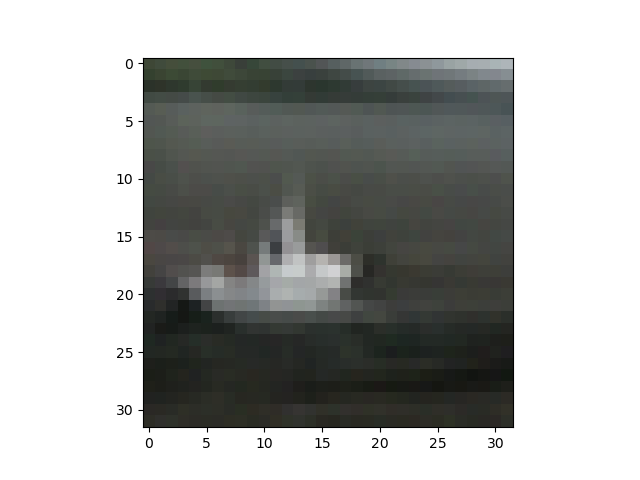

In [30]:
plt.figure()

plt.imshow(final_x[0].numpy().transpose(1,2,0))

In [42]:
num_timesteps=1000
axis_x = np.arange(num_timesteps)
skip = 20
seq1 = range(0, num_timesteps , skip)

seq2 = np.linspace(0, np.sqrt( num_timesteps * 0.8),  args.timesteps)** 2
seq2 = [int(s) for s in list(seq2)]